In [1]:
%matplotlib inline

In [2]:
from mne.inverse_sparse.mxne_inverse import _make_sparse_stc
from mne import read_forward_solution
from mne.viz import plot_sparse_source_estimates
import mne

import numpy as np

In [3]:
import os 

os.environ['SUBJECTS_DIR'] = '/home/anujanegi/tj/bdsg/freesurfer/subjects'
PATH_TO_ESTIMATES = "/home/anujanegi/tj/bdsg/BSI-Zoo/bsi_zoo/tests/data/estimates"
SOLVER_NAMES = ['iterative_L1' , 'iterative_L2', 'iterative_sqrt', 'iterative_L1_typeII', 'iterative_L2_typeII', 'gamma_map']

------------------------------
For iterative L1 method...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
No vertices estimated!
------------------------------
For iterative L2 method...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desi

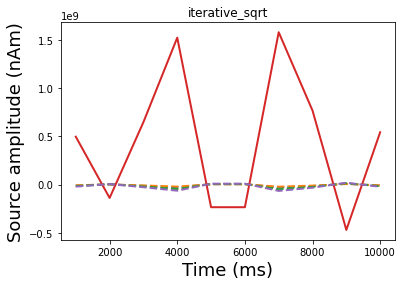

------------------------------
For iterative L1 typeII method...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
No vertices estimated!
------------------------------
For iterative L2 typeII method...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces

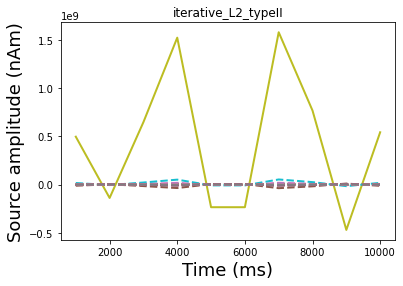

------------------------------
For gamma map method...
------------------------------
Reading forward solution from bsi_zoo/tests/data/CC120166-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Total number of active sources: 29


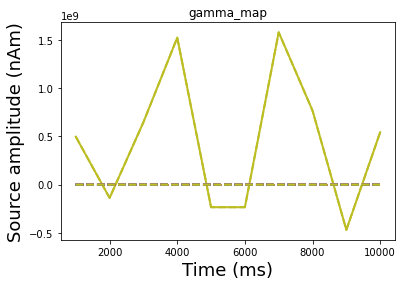

  File "/home/anujanegi/anaconda3/envs/mne/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "/home/anujanegi/anaconda3/envs/mne/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


In [5]:
for solver in SOLVER_NAMES:
    print('-'*30)
    print('For %s method...'%solver.replace('_', ' '))
    print('-'*30)
    
    x = np.load(os.path.join(PATH_TO_ESTIMATES, solver+'_x_10.npy'))
    x_hat = np.load(os.path.join(PATH_TO_ESTIMATES, solver+'_x_hat_10.npy'))
    
    fwd_fname = "bsi_zoo/tests/data/CC120166-fwd.fif"
    fwd = read_forward_solution(fwd_fname)
    fwd = mne.convert_forward_solution(fwd, force_fixed=True)

    active_set = np.linalg.norm(x, axis=1) != 0
    active_set_hat = np.linalg.norm(x_hat, axis=1) != 0

    stc = _make_sparse_stc(
        x[active_set], active_set, fwd, tmin=1, tstep=1
    )  # ground truth
    stc_hat = _make_sparse_stc(
        x_hat[active_set_hat], active_set_hat, fwd, tmin=1, tstep=1
    )  # estimate
    
    if stc_hat.vertices[0].any() or stc_hat.vertices[1].any():
        brain = stc.plot(hemi='both')
        brain.add_text(0.1, 0.9, solver+' - GT', 'title', font_size=16)

        brain_hat = stc_hat.plot(hemi='both')
        brain_hat.add_text(0.1, 0.9, solver+' - estimate', 'title', font_size=16)
    
    else:
        print('No vertices estimated!')

#     if stc_hat.vertices[0].any() or stc_hat.vertices[1].any():
#         plot_sparse_source_estimates(
#                 fwd["src"],
#                 [stc, stc_hat],
#                 bgcolor=(1, 1, 1),
#                 opacity=0.1,
#                 fig_name=solver,
#                 # labels=[np.asarray(['Ground truth']), np.asarray(['Estimate'])]
#             )
#     else:
#         print('No vertices estimated!')